# [Advent of Code 2021](https://adventofcode.com/2021)

Partially inspired by [Norvig's pytudes](https://github.com/norvig/pytudes/blob/main/ipynb/Advent-2020.ipynb), although I probably won't be using the same style.

Goals
------
* Try to finish all gold stars on day of puzzle
* Learn new python features
* Investigate github copilot

In [1]:
# Imports

from collections import defaultdict, Counter
import itertools
from functools import lru_cache
import numpy as np
import numpy.typing as npt
import re
from typing import Callable, TypeVar

T = TypeVar('T')

# Helper functions

def data(day: int, parser: Callable[[str], T] = str) -> list[T]:
  with open(f"../data/2021/day{day}.txt") as f:
    return [parser(line.strip()) for line in f.readlines()]

def split_csv_row(row: str) -> list[int]:
  return [int(x) for x in row.split(',')]

def split_int_row(row: str) -> list[int]:
  return [int(x) for x in row]

## Day 1

Determine number of increments in list

In [13]:
data1 = data(1, int)

In [14]:
def day1(data: list[int]) -> int:
  count, current = 0, data[0]
  for i in data[1:]:
    if i > current:
      count += 1
    current = i
  return count

day1(data1)

1688

In [48]:
def win3(data: list[int]) -> list[int]:
  for i in range(len(data) - 2):
    yield sum(data[i:i+3])

day1(list(win3(data1)))

1728

## Day 2

Maintain sum of depth and length

In [97]:
data2 = data('2')

In [22]:
def day2(data: list[str]) -> int:
  depth, length = 0, 0
  for i in data:
    mode, amount = i.split(' ')
    amount = int(amount)
    match mode:
      case 'forward':
        length += amount
      case 'down':
        depth += amount
      case 'up':
        depth -= amount
  return depth * length

day2(data2)

1451208

In [26]:
def day2_2(data: list[str]) -> int:
  depth, length, aim = 0, 0, 0
  for i in data:
    mode, amount = i.split(' ')
    amount = int(amount)
    match mode:
      case 'forward':
        length += amount
        depth += amount * aim
      case 'down':
        aim += amount
      case 'up':
        aim -= amount
  return depth * length

day2_2(data2)

1620141160

## Day 3

Can probably be solved with bit tricks, but I'll just implement them as array problems.

In [98]:
data3 = data('3')

def binlist2int(l: list[int]) -> int:
  return int("".join(str(i) for i in l), 2)

In [177]:
def day3(data: list[int]):
  total = len(data)
  size = len(data[0])
  sums = [0] * size
  for binary in data:
    for i, v in enumerate(binary):
      sums[i] += int(v)
  
  gamma = [0 if total - i > i else 1 for i in sums]
  epsilon = [i ^ 1 for i in gamma]
  return binlist2int(gamma) * binlist2int(epsilon)

day3(data3)

2954600

In [179]:
def find_boundary(data: list[str], start: int, end: int, index: int) -> int:
  # TODO: this can be implemented as binary search
  for i, v in enumerate(data[start:end+1]):
    if v[index] == '1':
      return start + i
  return start

def scrubber(data: list[str], lcd: bool) -> int:
  # Run "binary search"
  low, high = 0, len(data) - 1
  for target in range(len(data[0])):
    index = low + ((high - low + 1) // 2)
    item = data[index][target]

    if lcd and item == '0':
      # Select all '1's in the bottom half
      low = find_boundary(data, index, high, target)
    elif lcd and item == '1':
      # Select all '0's in the top half
      high = find_boundary(data, low, index, target) - 1
    elif item == '0':
      # Select all '0's from the top through to the bottom half
      high = find_boundary(data, index, high, target) - 1
    else:
      # Select all '1' starting from the top half to the end
      low = find_boundary(data, low, index, target)
    
    if low == high:
      break

  return data[low]

def day3_2(data: list[str]) -> int:
  data = sorted(data)
  oxygen = scrubber(data, False)
  c02 = scrubber(data, True)
  return binlist2int(oxygen) * binlist2int(c02)

day3_2(data3)

1662846

## Day 4
Reference storing Bingo Boards

In [99]:
data4 = data('4')

class BingoBoard:
  def __init__(self):
    self.board = []
    self.size = 0
    # TODO: this state should be stored elsewhere
    self.rows = []
    self.cols = []
    
  def add_row(self, row: list[int]):
    self.board.append(row)
    if not self.size:
      self.size = len(row)
      self.rows = [0] * self.size
      # Assume column size is same as row size
      self.cols = [0] * self.size

def parse_data4(data: list[str]) -> tuple[list[int], list[BingoBoard]]:
  numbers = [int(x) for x in data[0].split(',')]
  boards, board = [], None
  for row in data[1:]:
    if row == '':
      board = BingoBoard()
      boards.append(board)
    else:
      board.add_row([int(x) for x in re.split('\s+', row)])
  return numbers, boards

def analyze_boards(boards: list[BingoBoard]) -> dict[list[tuple[int,int,BingoBoard]]]:
  # For each number, store the row and column with every board it was found in
  keys = defaultdict(lambda: [])
  for board in boards:
    for i, row in enumerate(board.board):
      for j, v in enumerate(row):
        keys[v].append((i, j, board))
  return keys

In [75]:
def calculate_score(board: BingoBoard, numbers: set[int]) -> int:
  score = 0
  for row in board.board:
    for v in row:
      if v not in numbers:
        score += v
  return score

def day4(data: list[str]) -> int:
  numbers, boards = parse_data4(data)  
  keys = analyze_boards(boards)
  selected = set()
  for number in numbers:
    if number in selected:
      continue
    selected.add(number)
    for i, j, board in keys[number]:
      board.rows[i] += 1
      board.cols[j] += 1
      if board.size == board.rows[i] or board.size == board.cols[j]:
        return calculate_score(board, selected) * number

day4(data4)

4512

In [82]:
def retroactive_selected(inputs: list[int], end: int) -> int:
  index = inputs.index(end) + 1
  return set(inputs[:index])

def day4_2(data: list[str]) -> int:
  numbers, boards = parse_data4(data)  
  keys = analyze_boards(boards)
  selected = set()
  completed, last_winner, last_num = set(), None, 0
  for number in numbers:
    if number in selected:
      continue
    selected.add(number)
    for i, j, board in keys[number]:
      if board in completed:
        continue
      board.rows[i] += 1
      board.cols[j] += 1
      if board.size == board.rows[i] or board.size == board.cols[j]:
        completed.add(board)
        last_winner, last_num = board, number
  return calculate_score(last_winner, retroactive_selected(numbers, last_num)) * last_num

day4_2(data4)

5586

## Day 5

Some possible ideas for solutions: 
1. use vector products between each pair (n^2) and remove duplicates somehow
2. use a 2-d interval tree and detect where sums on a point are greater than 1
3. fill a 2-d grid and iterate through points

Implementing with idea 3 for now, since size of grid is small relative to number of lines

In [102]:
Line = tuple[tuple[int, int], tuple[int, int]]

def parse5(line: str) -> list[Line]:
  result = re.split('[\s,]', line)
  return (
    (int(result[0]), int(result[3])), # xs
    (int(result[1]), int(result[4])) # ys
  )

data5 = data('5', parse5)

In [103]:
class BaseHydroVents:
  def __init__(self, size: int) -> None:
    self.grid = np.zeros([size, size])

  def add_line(self, line: Line) -> None:
    if line[0][0] == line[0][1]:
      self.add_vertical_line(sorted(line[1]), line[0][0])
    elif line[1][0] == line[1][1]:
      self.add_horizontal_line(sorted(line[0]), line[1][0])
    else:
      self.add_diagonal_line(line)

  def add_diagonal_line(self, line: Line) -> None:
    # Stub
    return

  def add_horizontal_line(self, xs: tuple[int, int], y: int) -> None:
    for x in range(xs[0], xs[1] + 1):
      self.grid[y][x] += 1

  def add_vertical_line(self, ys: tuple[int, int], x: int) -> None:
    for y in range(ys[0], ys[1] + 1):
      self.grid[y][x] += 1

def max_vent_point(data: list[Line]) -> int:
  return max([max(max(x[0]), max(x[1])) for x in data])

def day5(data: list[Line]) -> int:
  size = max_vent_point(data) + 1
  vents = BaseHydroVents(size)
  for line in data:
    vents.add_line(line)
  mask = vents.grid > 1
  return np.count_nonzero(mask)

day5(data5)


4728

In [104]:
class HydroVents (BaseHydroVents):
  def __init__(self, size: int) -> None:
    self.grid = np.zeros([size, size])

  def add_diagonal_line(self, line: Line) -> None:
    # Only supports 45 degree lines
    xs, ys = line[0], line[1]
    dx = 1 if xs[1] > xs[0] else -1
    dy = 1 if ys[1] > ys[0] else -1
    length = abs(xs[1] - xs[0]) + 1
    for i in range(length):
      self.grid[ys[0] + dy * i][xs[0] + dx * i] += 1

def day5_2(data: list[Line]) -> int:
  size = max_vent_point(data) + 1
  vents = HydroVents(size)
  for line in data:
    vents.add_line(line)
  mask = vents.grid > 1
  return np.count_nonzero(mask)

day5_2(data5)


17717

## Day 6

Seems like a DP problem

In [4]:
data6 = data('6', split_csv_row)

In [99]:
@lru_cache(None)
def spawns6(days: int):
  if days < 6:
    return 1
  return spawns6(days-7) + spawns8(days-7)

@lru_cache(None)
def spawns8(days: int):
  if days < 8:
    return 1
  return spawns6(days-9) + spawns8(days-9)

def day6(data: list[int], days: int) -> int:
  result = [spawns6(days + 6 - i) for i in data]
  return sum(result)

day6(data6, 79)

394994

In [100]:
day6(data6, 255)

1765974267455

## Day 7

Minimize v-shaped curve $ |F(c)| $ where $ A - c = F $ using binary search

In [34]:
data7 = data(7, split_csv_row)[0]

In [38]:
CostFunction7 = Callable[[npt.ArrayLike], int]
def fuel_used(input: npt.ArrayLike) -> int:
  return np.sum(np.abs(input))

def deltas(input: npt.ArrayLike, current: int, cost: CostFunction7) -> tuple[int, int, int]:
  y = cost(input - current)
  left = cost(input - current - 1)
  right = cost(input - current + 1)
  return left, y, right

# TODO: could use scipy.optimize.minimize instead
def bsearch7(input: npt.ArrayLike, low: int, high: int, cost: CostFunction7) -> int:
  while low < high:
    mid = (low + high) // 2
    left, y, right = deltas(input, mid, cost)
    if left < y:
      low = mid + 1
    elif right < y:
      high = mid
    else:
      low, high = mid, mid
  return mid

def day7(data: list[int], cost: CostFunction7) -> int:
  input = np.array(data)
  hmin, hmax = np.min(input), np.max(input)
  result = bsearch7(input, hmin, hmax, cost)
  return cost(input - result)

day7(data7, fuel_used)

343605

In [39]:
def triangular_number(n: int) -> int:
  return n * (n + 1) // 2

def fuel_used2(input: npt.ArrayLike) -> int:
  return np.sum(triangular_number(np.abs(input)))

day7(data7, fuel_used2)

96744904

## Day 8

Set intersections

In [92]:
data8 = data('8')

In [101]:
Knowns9 = dict[int, set[str]]

items_by_length = defaultdict(lambda: None, {
  2: 1,
  3: 7,
  4: 4,
  7: 8
})
def disambiguate6(item: set[str], knowns: Knowns9) -> int:
    if knowns[1] - item:
      return 6
    elif not knowns[4] - item:
      return 9
    else:
      return 0
def disambiguate5(item: set[str], knowns: Knowns9) -> int:
    if not knowns[7] - item:
      return 3
    elif len(knowns[6] - item) == 1:
      return 5
    else:
      return 2

def group_items(data: list[str]) -> tuple[Knowns9]:
  knowns = {}
  unknowns = []
  for i in data:
    item = set(i)
    match len(item):
      case 6:
        unknowns.append(item)
      case _:
        knowns[items_by_length[len(item)]] = item
  for item in unknowns:
    knowns[disambiguate6(item, knowns)] = item
  # Disambiguate5 not required to be run, we can do that while decoding the output
  return knowns

def parse_line(line: str) -> str:
  input, output = tuple(group.split(' ') for group in line.split(' | '))
  knowns = group_items(input)
  for i in output:
    item = set(i)
    match len(item):
      case 5:
        yield disambiguate5(item, knowns)
      case 6:
        yield disambiguate6(item, knowns)
      case _:
        yield items_by_length[len(item)]

# Overly complicated way to do what's required, but it's pretty clear what's coming in part 2
def day8(data: list[str]) -> int:
  count = 0
  targets = items_by_length.values()
  for line in data:
    result = parse_line(line)
    for number in result:
      if number in targets:
        count += 1
  return count

day8(data8)

383

In [93]:
def day8_2(data: list[str]) -> int:
  total = 0
  for line in data:
    result = parse_line(line)
    total += int(''.join(str(i) for i in result))
  return total

day8_2(data8)

998900

## Day 9
* Part 1: numpy array masking
* Part 2: Recursive search from results of part 1

In [5]:
data9 = np.array(data('9', split_int_row))

In [53]:
def get_basins(data: npt.ArrayLike) -> npt.ArrayLike:
  zero_row, zero_col = np.full((1, data.shape[1]), 10), np.full((data.shape[0], 1), 10)
  a = np.concatenate((data[1:], zero_row))
  b = np.concatenate((zero_row, data[:-1]))
  c = np.concatenate((data[:, 1:], zero_col), axis=1)
  d = np.concatenate((zero_col, data[:, :-1]), axis=1)

  mask = (data - a < 0) & (data - b < 0) & (data - c < 0) & (data - d < 0)
  indices = np.where(mask)
  return [(index[1], index[0]) for index in zip(indices[0], indices[1])]

def day9(data: npt.ArrayLike) -> int:
  basins = get_basins(data)
  return sum([data[y][x] for x, y in basins]) + len(basins)

day9(data9)

508

In [61]:
def day9_2(data: npt.ArrayLike) -> int:
  claimed = set()
  size = data9.shape

  def claim(x: int, y: int) -> int:
    if x < 0 or y < 0 or x >= size[1] or y >= size[0]:
      return 0
    if (x, y) in claimed:
      return 0
    if data[y][x] == 9:
      return 0
    claimed.add((x, y))
    return 1 + claim(x+1, y) + claim(x-1, y) + claim(x, y+1) + claim(x, y - 1)

  basins = [] # TODO: use 3-heap instead
  for (x, y) in get_basins(data):
    if basin_size := claim(x, y):
      basins.append(basin_size)
  return np.prod(sorted(basins, reverse=True)[:3])

day9_2(data9)

1564640

## Day 10
Stack stuff

In [7]:
data10 = data('10')

In [8]:
opens = {
  '(': ')',
  '[': ']',
  '{': '}',
  '<': '>',
}
error_scores = {
  ')': 3,
  ']': 57,
  '}': 1197,
  '>': 25137,
}

def handle_line10(line: str) -> str:
  stack = []
  for i in line:
    if i in opens:
      stack.append(i)
    elif opens[stack[-1]] == i:
      stack.pop()
    else:
      return i
  return stack

def day10(data: list[str]) -> int:
  lines = ([handle_line10(line) for line in data])
  errors = Counter([line for line in lines if type(line) is str])
  return sum(error_scores[i] * errors[i] for i in errors)

day10(data10)


319233

In [9]:
closing_scores = {
  ')': 1,
  ']': 2,
  '}': 3,
  '>': 4,
}

def closing_score(close: list[str]) -> int:
  score = 0
  for i in reversed(close):
    score = score * 5 + closing_scores[opens[i]]
  return score

def day10_2(data: list[str]) -> int:
  lines = ([handle_line10(line) for line in data])
  scores = [closing_score(line) for line in lines if type(line) is list]
  mid = len(scores) // 2
  return sorted(scores)[mid]

day10_2(data10)

1118976874

## Day 11
Array operations

In [202]:
data11 = np.array(data('11', split_int_row))

In [214]:
def run_flashes(data: npt.ArrayLike, flashed: set[int], size: tuple[int, int], debug = False) -> bool:
  changed = False
  for i in reversed(np.argsort(data.flatten())):
    x, y = i % size[1], i // size[1]
    if data[y][x] > 9 and i not in flashed:
      for index in itertools.product([x-1, x, x+1], [y-1, y, y+1]):
        if index[0] == x and index[1] == y:
          continue
        if index[0] < 0 or index[0] >= size[1]:
          continue
        if index[1] < 0 or index[1] >= size[0]:
          continue
        data[index[1]][index[0]] += 1
      flashed.add(i)
      changed = True
  return changed

def check_flashes(data: npt.ArrayLike, size: tuple[int, int], debug = False) -> set[int]:
  flashed = set()
  changed = True
  data += 1
  while changed:
    changed = run_flashes(data, flashed, size, debug)
  np.put(data, list(flashed), [0])
  return flashed

def day11(data: npt.ArrayLike) -> int:
  flashes = 0
  size = data.shape
  current = data.copy()
  for _ in range(100):
    flashes += len(check_flashes(current, size))
  return flashes

day11(data11)  

1719

In [215]:
def day11_2(data: npt.ArrayLike) -> int:
  size = data.shape
  current = data.copy()
  for i in range(10000):
    check_flashes(current, size)
    if np.sum(current) == 0:
      return i + 1
  raise Exception('Too few iterations')

day11_2(data11)

232

## Day 12

Some graph stuff

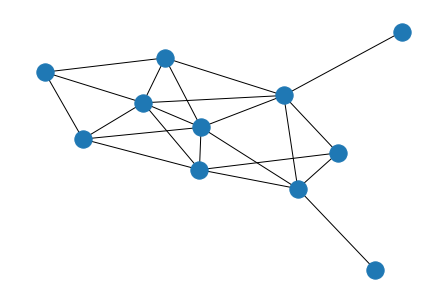

In [73]:
import networkx as nx

G = nx.Graph()

def add_edge(line: str):
  a, b = line.split('-')
  G.add_edge(a, b)
_ = data('12', add_edge)

nx.draw(G)

In [74]:

def day12(G: nx.Graph, target: str) -> int:
  visited = set()
  
  def backtrack(node: str):
    if node == 'start':
      return 1
    if node in visited:
      return 0
    if node[0].islower():
      visited.add(node)
    score = 0
    for neighbor in G[node]:
      score += backtrack(neighbor)
    if node[0].islower():
      visited.remove(node)
    return score

  return backtrack(target)

day12(G, 'end')
    

5252

In [78]:
def day12_2(G: nx.Graph) -> int:
  visited = Counter()
  
  def backtrack(node: str, duplicate = None):
    if node == 'start':
      return 1
    if visited[node] > 0:
      if node == 'end' or duplicate:
        return 0
      duplicate = node
    if node[0].islower():
        visited[node] += 1
    score = 0
    for neighbor in G[node]:
      score += backtrack(neighbor, duplicate)
    if node[0].islower():
      visited[node] = max(0, visited[node] - 1)
    return score
  return backtrack('end')

day12_2(G)
    

147784